# Qamomile における QiskitTranspiler の使用方法

このチュートリアルでは、Qamomile における QiskitTranspiler の使い方を紹介し、ユーザーが効果的に活用するための主要な例を示します。

## ハミルトニアンの Qiskit への変換

まずはテスト用のハミルトニアンを定義し、それを変換器（トランスパイラ）を用いて Qiskit 互換の形式に変換します。  
このステップでは、私たちのライブラリで定義されたハミルトニアンが、Qiskit に認識される演算子へとスムーズに変換される様子を示します。

In [1]:
import jijmodeling as jm
import jijmodeling_transpiler.core as jmt
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import qiskit.primitives as qk_pr
from scipy.optimize import minimize

import qamomile
from qamomile.core.operator import Hamiltonian, Pauli, X, Y, Z
from qamomile.core.circuit import QuantumCircuit as QamomileCircuit
from qamomile.core.circuit import (
    QuantumCircuit,
    SingleQubitGate,
    TwoQubitGate,
    ParametricSingleQubitGate,
    ParametricTwoQubitGate,
    SingleQubitGateType,
    TwoQubitGateType,
    ParametricSingleQubitGateType,
    ParametricTwoQubitGateType,
    Parameter
)
from qamomile.core.circuit.drawer import plot_quantum_circuit
from qamomile.qiskit.transpiler import QiskitTranspiler

このスニペットでは、X・Y・Z などのパウリ演算子を使って独自に定義したハミルトニアンから始め、  `QiskitTranspiler` を用いて Qiskit に直接対応する形式へと変換します。
`qiskit_hamiltonian` を出力することで、その変換が正しく行われたかを確認できます。

In [2]:
hamiltonian = Hamiltonian()
hamiltonian += X(0)*Z(1)
hamiltonian += Y(0)*Y(1)*Z(2)*X(3)*X(4)

transpiler = QiskitTranspiler()
qiskit_hamiltonian = transpiler.transpile_hamiltonian(hamiltonian)

qiskit_hamiltonian

SparsePauliOp(['IIIZX', 'XXZYY'],
              coeffs=[1.+0.j, 1.+0.j])

## パラメータ化された量子回路の構築

次に、QamomileCircuit を使ってパラメータ化された量子回路を構築します。  
ここでは、1量子ビット回転（rx, ry, rz）やその制御付きバージョン（crx, crz, cry）、さらに2量子ビットのエンタングルゲート（rxx, ryy, rzz）を含めます。  
パラメータ（theta, beta, gamma）を使うことで、変分的な柔軟な調整が可能になります。

In [3]:
qc = QamomileCircuit(3)
theta = Parameter("theta")
beta = Parameter("beta")
gamma = Parameter("gamma")

qc.rx(theta, 0)
qc.ry(beta, 1)
qc.rz(gamma, 2)
qc.crx(gamma, 0 ,1)
qc.crz(theta, 1 ,2)
qc.cry(beta, 2 ,0)
qc.rxx(gamma, 0 ,1)
qc.ryy(theta, 1 ,2)
qc.rzz(beta, 2 ,0)

transpiler = QiskitTranspiler()
qk_circuit = transpiler.transpile_circuit(qc)

## MaxCut問題の定式化と量子形式への変換

以下では、古典的な最適化問題である MaxCut をどのようにしてイジング形式のハミルトニアンにエンコードするかを示します。  
次に、QAOAスタイルのアンサッツ回路を構築し、それを実行および最適化することで、MaxCutインスタンスの解を求めようとします。

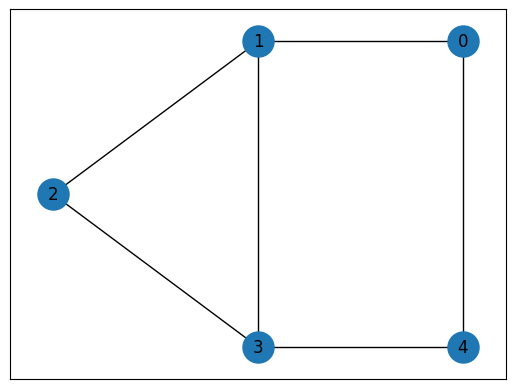

In [4]:
def maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e, (1 - si * sj))
    problem += obj
    return problem

def maxcut_instance():
    # MaxCutインスタンスのために簡単なグラフを構築します。
    G = nx.Graph()
    G.add_nodes_from([0, 1, 2, 3, 4])
    G.add_edges_from([(0, 1), (0, 4), (1, 2), (1, 3), (2, 3), (3, 4)])
    E = [list(edge) for edge in G.edges]
    instance_data = {"V": G.number_of_nodes(), "E": E}
    pos = {0: (1, 1), 1: (0, 1), 2: (-1, 0.5), 3: (0, 0), 4: (1, 0)}
    nx.draw_networkx(G, pos, node_size=500)
    return instance_data

problem = maxcut_problem()
instance_data = maxcut_instance()
interpreter = jm.Interpreter(instance_data)
compiled_instance = interpreter.eval_problem(problem)

# コンパイルした問題をQAOA形式へ変換する
qaoa_converter = qamomile.core.qaoa.QAOAConverter(compiled_instance)
qaoa_converter.ising_encode()

p = 5
qaoa_hamiltonian = qaoa_converter.get_cost_hamiltonian()
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=p)

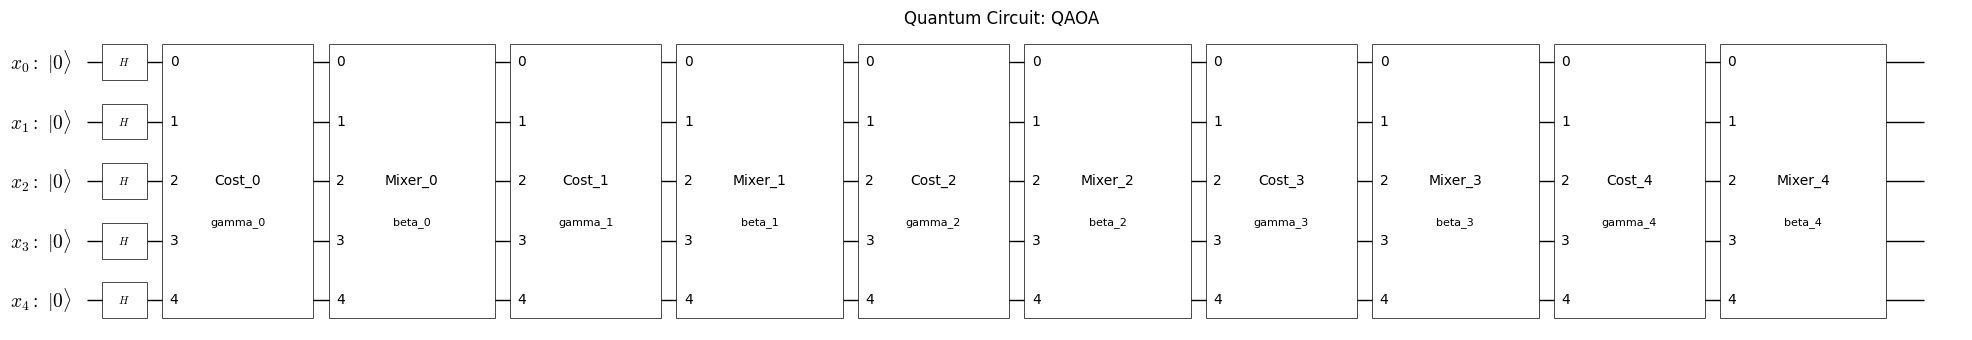

In [5]:
plot_quantum_circuit(qaoa_circuit)

これで、MaxCut問題をQAOAのようなアルゴリズムに適したコストハミルトニアンに変換しました。パラメータ `p` は、問題ハミルトニアンとミキサーハミルトニアンのレイヤー数を決定します。各レイヤーのパラメータは変分的であり、期待値を最小化するように調整されます。理想的には、これによりMaxCutインスタンスの良い解が得られます。

## QiskitでのQAOA回路のトランスパイルと実行

QAOA回路とハミルトニアンが定義されたので、再びトランスパイラを使用して、QAOA回路とコストハミルトニアンをQiskit形式に変換します：

In [6]:
transpiler = QiskitTranspiler()
# QAOA回路をQiskit用へ変換する
qk_circuit = transpiler.transpile_circuit(qaoa_circuit)

# QAOAハミルトニアンをQiskit用へ変換する
qk_hamiltonian = transpiler.transpile_hamiltonian(qaoa_hamiltonian)
qk_hamiltonian

SparsePauliOp(['IIIZZ', 'ZIIIZ', 'IIZZI', 'IZIZI', 'IZZII', 'ZZIII', 'IIIII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j, -3. +0.j])

ここで、`qk_circuit` は Qamomile の QAOA アンサッツから生成された Qiskit 回路であり、`qk_hamiltonian` は数理モデルに基づいて Qamomile のハミルトニアンから構築されたものです。

## パラメータの最適化

最後に、変分パラメータを最適化し、より良い結果（例えば、MaxCut 目的関数に対する低コスト）をもたらすパラメータを見つけることを試みます。

In [7]:
cost_history = []
# コスト推定関数
estimator = qk_pr.StatevectorEstimator()


def estimate_cost(param_values):
    try:
        job = estimator.run([(qk_circuit, qk_hamiltonian, param_values)])
        result = job.result()[0]
        cost = result.data["evs"]
        cost_history.append(cost)
        return cost
    except Exception as e:
        print(f"Error during cost estimation: {e}")
        return np.inf


# 初期パラメータを作成する
initial_params = np.random.uniform(low=-np.pi / 4, high=np.pi / 4, size=2 * p)

# QAOA最適化を実行する
result = minimize(
    estimate_cost,
    initial_params,
    method="COBYLA",
    options={"maxiter": 2000},
)
print(result)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -4.751158474226468
       x: [-6.340e-01 -5.107e-01  6.310e-01  2.604e-01 -6.435e-01
            4.868e-01  7.951e-01 -5.391e-01 -3.380e-01  4.780e-01]
    nfev: 2000
   maxcv: 0.0


## 結果の可視化

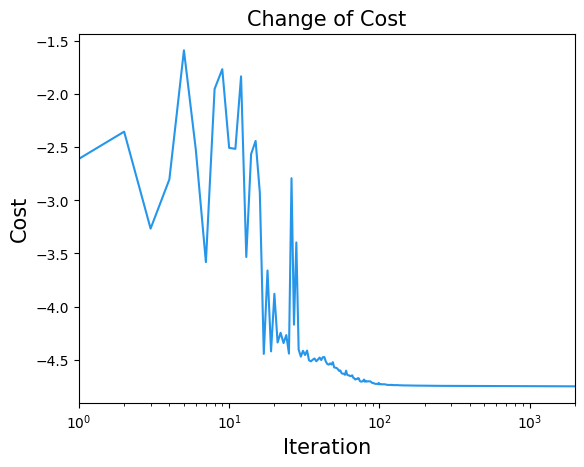

In [8]:
plt.title("Change of Cost", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Cost", fontsize=15)
plt.xscale("log")
plt.xlim(1, result.nfev)
plt.plot(cost_history, label="Cost", color="#2696EB")
plt.show()

最適化されたパラメータが得られたら、Qiskit の `StatevectorSampler` を使用して、パラメータ化された量子回路からサンプリングし、回路の測定結果（カウント）を取得します。

In [9]:
# 最適化されたQAOA回路を実行する
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
job = sampler.run([(qk_circuit, result.x)], shots=10000)
job_result = job.result()[0]
qaoa_counts = job_result.data["meas"]

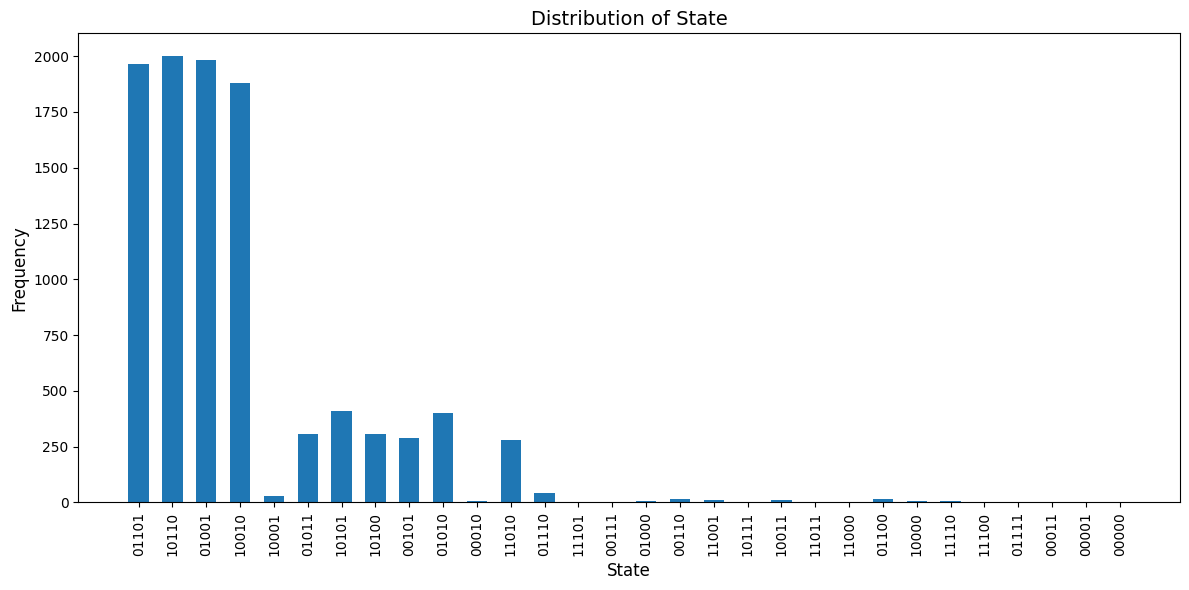

In [10]:
# プロットのためのデータを準備する
keys = list(qaoa_counts.get_counts().keys())
values = list(qaoa_counts.get_counts().values())

# プロットする
plt.figure(figsize=(12, 6))
plt.bar(keys, values, width=0.6)
plt.xlabel("State", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of State", fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

## 結果の評価  
前に得られた `qaoa_counts` から、`qaoa_converter.decode` を使ってサンプルセットに変換することができます。  
このサンプルセットから実行可能な解のみを選択し、目的関数の値の分布を調べます。

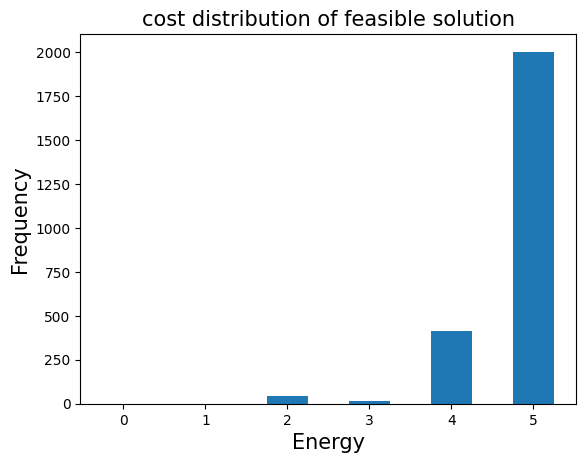

In [11]:
sampleset = qaoa_converter.decode(transpiler, qaoa_counts) 
feasible_ids = [key for key, value in sampleset.feasible.items() if value]
energies = []
frequencies = []
for entry in sampleset.raw.objectives.entries:
    energies.append(entry.value)
    feasible_count = len([_id for _id in entry.ids if _id in feasible_ids])
    frequencies.append(feasible_count)

plt.bar(energies, frequencies, width=0.5)
plt.title("cost distribution of feasible solution", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Energy", fontsize=15)
plt.show()